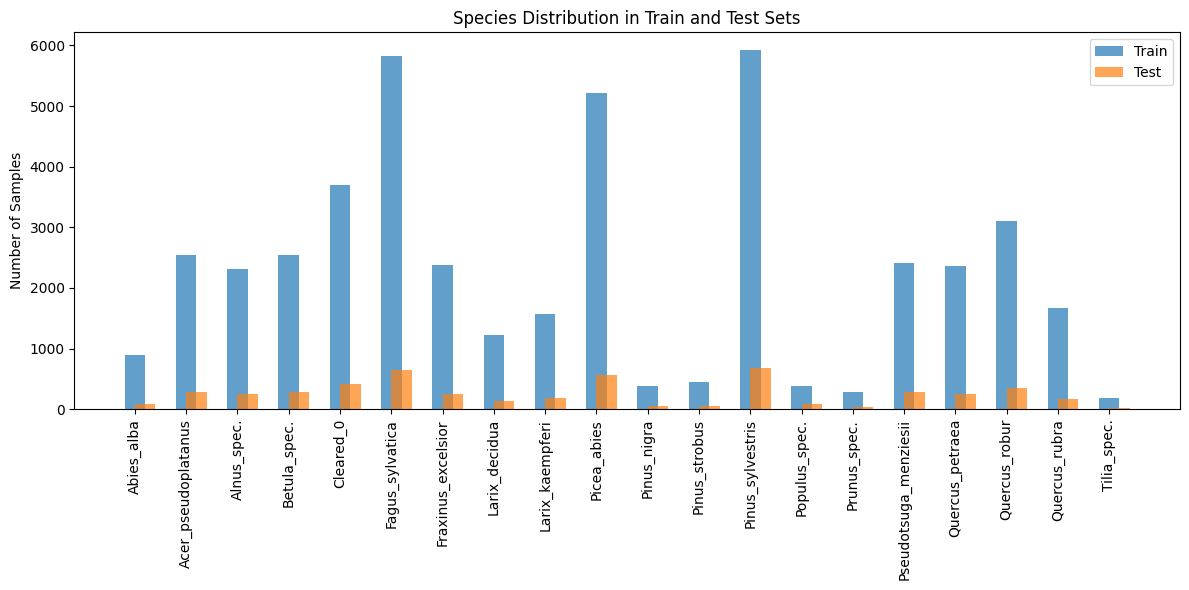

In [6]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Load file paths
train_files = [line.strip() for line in open("/Users/user/Downloads/DLF/train_filenames.lst")]
test_files = [line.strip() for line in open("/Users/user/Downloads/DLF/test_filenames.lst")]

# Extract species names from file names
def extract_species(filename):
    parts = filename.split('_')
    return f"{parts[0]}_{parts[1]}"  # Join genus and species

train_species = [extract_species(f) for f in train_files]
test_species = [extract_species(f) for f in test_files]


# Count occurrences of each species
train_counts = Counter(train_species)
test_counts = Counter(test_species)

# Get sorted species names
species_list = sorted(set(train_species + test_species))
train_values = [train_counts[species] for species in species_list]
test_values = [test_counts[species] for species in species_list]

# Plot distribution
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(species_list))
ax.bar(x, train_values, width=0.4, label="Train", align='center', alpha=0.7)
ax.bar(x, test_values, width=0.4, label="Test", align='edge', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(species_list, rotation=90)
ax.set_ylabel("Number of Samples")
ax.set_title("Species Distribution in Train and Test Sets")
ax.legend()
plt.tight_layout()
plt.show()
